<img src="../../images/QISKit-c.gif" alt="Note: In order for images to show up in this jupyter notebook you need to select File => Trusted Notebook" width="250 px" align="left">

## _*Single-qubit state tomography*_ 

The latest version of this notebook is available on https://github.com/IBM/qiskit-sdk-py/tree/master/scripts.

For more information about how to use the Quantum Experience, consult the [IBM Quantum Experience tutorials](https://quantumexperience.ng.bluemix.net/qstage/#/tutorial?sectionId=c59b3710b928891a1420190148a72cce&pageIndex=0), or check out the [community](https://quantumexperience.ng.bluemix.net/qstage/#/community).

***
### Contributors
Andrew Cross

## Introduction

State tomography is a method for estimating a quantum state. A single-qubit state is given by a density matrix $\rho=(I+a_xX+a_yY+a_zZ)/2$ that is fully determined by the expectation value of each Pauli operator. For example, $\langle X\rangle = \mathrm{Tr}(X\rho) = a_x$. The resulting vector $(a_x,a_y,a_z)$ is called the Bloch vector. Since $\rho$ is positive and $\mathrm{Tr}(\rho)=1$, this means $\mathrm{Tr}(\rho^2)\leq 1$. This implies that the Bloch vector lies on or within the unit sphere.

This notebook shows one simplified approach to single-qubit state tomography applied to quantum states of your choice. You can experiment with different input states by changing the "qasm" variable containing the state preparation circuit.

The first step imports required packages and initializes the API.

In [1]:
import sys
if sys.version_info < (3,0):
    raise Exception("Please use Python version 3 or greater.")

from IBMQuantumExperience import IBMQuantumExperience
import Qconfig
import qhelpers.tomo1 as tomo1
import qhelpers.misc as misc
from qhelpers.basicplotter import plot_bloch_vector

api = IBMQuantumExperience.IBMQuantumExperience(Qconfig.APItoken,Qconfig.config)


Next, we set the parameters of the experiment. The QASM source specifies a circuit to prepare the input state. The subset of tomography qubits in *tomo_qubit* are selected for state tomography. The helper method *generate_tomo1_circuits* will make three circuits by appending single-qubit rotations and measurements to the input QASM source. Each of these circuits measures a fixed Pauli observable, either $X$, $Y$, or $Z$, on the tomography qubits, in parallel. The remaining parameters select the device, the number of shots per Pauli observable, and the maximum number of credits to spend on the job.

The QASM source needs to satisfy some conditions to run on the Quantum Experience and work correctly with *generate_tomo1_circuits*. The first two lines must be 'OPENQASM 2.0;' and 'include "qelib1.inc";', and the circuit cannot include any measurements. There should be at least one qreg and at least one creg with the same size. By default, these are assumed to be 'q' and 'c', respectively, as they need to be for running on the real device. You can change them in the arguments to *generate_tomo1_circuits*.

In [2]:
# QASM source to prepare the input state
qasm = """
OPENQASM 2.0;
include "qelib1.inc";
qreg q[5];
creg c[5];
h q[0];
h q[2]; s q[2];
h q[4]; u1(pi/4) q[4];
"""
# A list of qubits for single-qubit state tomography
tomo_qubits = [0,1,2,4]
# Device to use
device = "real"  # use "simulator" or "real"
shots = 1024
max_credits = 3

The next line generates the QASM source for the job and submits it to the Quantum Experience.

In [3]:
# Generate QASM for the state tomography
job = tomo1.generate_tomo1_circuits(qasm, tomo_qubits)
# Submit the job
out = api.run_job(job, device, shots, max_credits)

The next line waits for the job to finish.

In [4]:
res = misc.wait_for_jobs([out['id']], api)

status = {'RUNNING': 1} (0 seconds)
status = {'RUNNING': 1} (5 seconds)
status = {'RUNNING': 1} (10 seconds)
status = {'RUNNING': 1} (15 seconds)
status = {'COMPLETED': 1} (20 seconds)


Finally, we gather the data we need from the results, compute the expectation values of each Pauli operator, and plot the Bloch vectors. Recall that each qubit has already been rotated by applying a single-qubit Clifford gate and measured in the $Z$ basis, so all of the expectation values are of Pauli $Z$.

In the real device, the measurements are not perfect. Ideally if the input state is $\rho=(1-p)|0\rangle\langle 0|+p|1\rangle\langle 1|,$ then $\langle Z\rangle=1-2p$. However, there is a nonzero probability $\epsilon_{0:1}$ of observing outcome 0 when actually given a 1 and vice versa. The probability of observing a zero becomes $P(0)=(1-p)(1-\epsilon_{0:1})+p\epsilon_{0:1}$ and likewise for $P(1)$. With assignment error such as this, $\langle Z\rangle'=\langle Z\rangle (1-(\epsilon_{0:1}+\epsilon_{1:0}))$, so each component of the Bloch vector has reduced magnitude. We do not compensate for this effect.

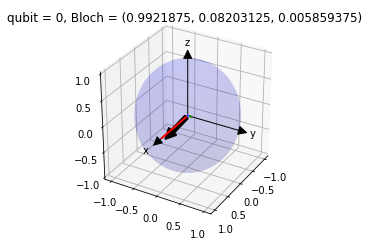

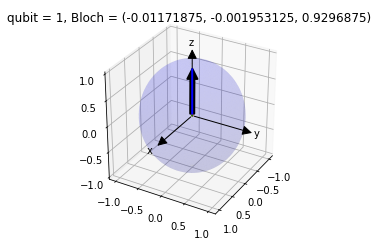

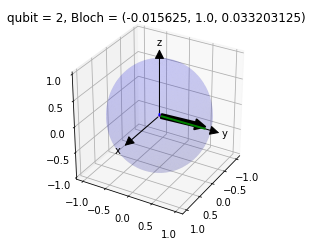

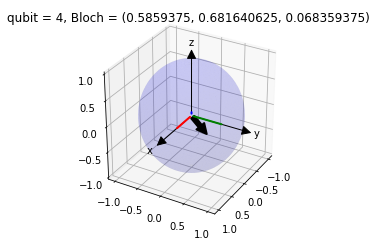

In [5]:
# Get the data corresponding to each measurement basis
xdat = misc.get_data(res[0],0)
ydat = misc.get_data(res[0],1)
zdat = misc.get_data(res[0],2)
# Compute the expectation value of the corresponding observable
# and put the result into the Bloch vector
bloch = {}
for q in tomo_qubits:
    bloch[q] = (tomo1.expectation_Z(xdat,q),
                tomo1.expectation_Z(ydat,q),
                tomo1.expectation_Z(zdat,q))

# Report and plot the results
for q in tomo_qubits:
    plot_bloch_vector(bloch[q], 'qubit = %d, Bloch = %s' % (q, bloch[q]))